# Commodity Price Analytics for Agricultural Development in India

**Commodity_Prices_Analytics_Using_PySpark.ipynb**

**Author:** Your Name
**Date:** 2025-10-05 13:48 UTC

---

**Objective:**
Use PySpark and Python (Pandas/Seaborn/Plotly) to analyze variety-wise daily market prices, produce farmer-centric insights, and build predictive models to forecast commodity prices. The notebook follows a professional structure similar to your Insurance analytics notebook: clear sections, explanations, and reproducible code.


## Table of Contents
1. Dataset Description
2. Environment Setup & Imports
3. Load Data (PySpark & Pandas)
4. Data Cleaning & Preprocessing
5. Exploratory Data Analysis (EDA)
6. Visualizations (Matplotlib / Seaborn / Plotly)
7. Advanced Analytics (Rolling, Seasonality, Volatility)
8. Predictive Modeling (sklearn & PySpark MLlib templates)
9. Key Insights, Recommendations & Impact for Farmers
10. Conclusion


## 1) Dataset Description

The dataset **`commodity_prices.csv`** should be placed in the same folder as this notebook. Expected columns (common names):
- `date` or `arrival_date`
- `state` or `market_state`
- `district` (optional)
- `commodity`
- `variety` or `grade`
- `modal_price` or `price`
- `arrival_quantity` (optional)

**Purpose:** Analyze daily variety-wise mandi prices to create actionable insights for farmers and policymakers, focusing on price stability, seasonality and short-term forecasting.

---


In [12]:
# 2) Environment Setup & Imports
# Run this cell first
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

# sklearn for local modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style='whitegrid', palette='muted', font_scale=1.05)
print('Environment ready. Ensure commodity_prices.csv is in the same folder as this notebook before loading.')

Environment ready. Ensure commodity_prices.csv is in the same folder as this notebook before loading.


In [13]:
# 3) Load Data (Pandas). PySpark template provided below for scalable runs.
csv_path = 'commodity_prices.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"{csv_path} not found. Please place the dataset in the notebook folder.")

df = pd.read_csv(csv_path, low_memory=False)
# normalize columns
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
print('Columns detected:')
print(df.columns.tolist())
print('\nDataset shape:', df.shape)
df.head()

Columns detected:
['state', 'district', 'market', 'commodity', 'variety', 'grade', 'arrival_date', 'min_price', 'max_price', 'modal_price', 'commodity_code']

Dataset shape: (1076, 11)


,state,district,market,commodity,variety,grade,arrival_date,min_price,max_price,modal_price,commodity_code
0,Telangana,Warangal,Warangal,Apple,Simla,Large,13/09/2025,12000,12000,12000,17
1,Telangana,Warangal,Warangal,Apple,Simla,Large,25/08/2025,11000,11000,11000,17
2,Telangana,Warangal,Warangal,Apple,Simla,Large,26/08/2025,10000,10000,10000,17
3,Telangana,Warangal,Warangal,Apple,Simla,Large,28/08/2025,12000,12000,12000,17
4,Telangana,Warangal,Warangal,Apple,Simla,Medium,04/09/2025,9000,9000,9000,17


In [14]:
# 4) Auto-detect common columns and basic conversion
possible_date = [c for c in df.columns if 'date' in c]
possible_price = [c for c in df.columns if 'price' in c or 'modal' in c or 'rate' in c]
possible_state = [c for c in df.columns if 'state' in c]
possible_commodity = [c for c in df.columns if 'commodity' in c]
possible_variety = [c for c in df.columns if 'variety' in c or 'grade' in c or 'varieties' in c]

date_col = possible_date[0] if possible_date else None
price_col = possible_price[0] if possible_price else None
state_col = possible_state[0] if possible_state else None
commodity_col = possible_commodity[0] if possible_commodity else None
variety_col = possible_variety[0] if possible_variety else None

print('Detected -> date:', date_col, 'price:', price_col, 'state:', state_col, 'commodity:', commodity_col, 'variety:', variety_col)

# Convert types
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
if price_col:
    df[price_col] = pd.to_numeric(df[price_col].astype(str).str.replace(',',''), errors='coerce')

# Quick missing value overview
missing = df.isnull().sum().sort_values(ascending=False)
print('\nTop missing columns:\n', missing.head(10))

# Basic ranges
if date_col:
    print('\nDate range:', df[date_col].min(), 'to', df[date_col].max())
if price_col:
    print('\nPrice summary:')
    display(df[price_col].describe())

Detected -> date: arrival_date price: min_price state: state commodity: commodity variety: variety

Top missing columns:
 state           0
district        0
market          0
commodity       0
variety         0
grade           0
arrival_date    0
min_price       0
max_price       0
modal_price     0
dtype: int64

Date range: 2025-08-24 00:00:00 to 2025-09-23 00:00:00

Price summary:


count     1076.000000
mean      4545.819703
std       2838.831455
min       1000.000000
25%       2287.500000
50%       3500.000000
75%       6053.500000
max      20000.000000
Name: min_price, dtype: float64

In [15]:
# 5) Data Cleaning & Preprocessing
# Copy and drop rows missing essential cols
df_clean = df.copy()
essential = []
if price_col: essential.append(price_col)
if date_col: essential.append(date_col)
if essential:
    df_clean = df_clean.dropna(subset=essential)

# Fill categorical blanks
if state_col: df_clean[state_col] = df_clean[state_col].fillna('UNKNOWN')
if commodity_col: df_clean[commodity_col] = df_clean[commodity_col].fillna('UNKNOWN')
if variety_col: df_clean[variety_col] = df_clean[variety_col].fillna('UNKNOWN')

# Extract temporal features
if date_col in df_clean.columns:
    df_clean['year'] = df_clean[date_col].dt.year
    df_clean['month'] = df_clean[date_col].dt.month
    df_clean['day'] = df_clean[date_col].dt.day
    df_clean['ym'] = df_clean[date_col].dt.to_period('M').astype(str)

# Detect and remove extreme outliers using IQR on price
if price_col:
    q1 = df_clean[price_col].quantile(0.25)
    q3 = df_clean[price_col].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 3*iqr, q3 + 3*iqr  # wider bounds to retain meaningful extremes
    before = len(df_clean)
    df_clean = df_clean[(df_clean[price_col] >= lower) & (df_clean[price_col] <= upper)]
    after = len(df_clean)
    print(f'Removed outliers: {before-after} rows')

print('Cleaned data shape:', df_clean.shape)
df_clean.head()

Removed outliers: 1 rows
Cleaned data shape: (1075, 15)


,state,district,market,commodity,variety,grade,arrival_date,min_price,max_price,modal_price,commodity_code,year,month,day,ym
0,Telangana,Warangal,Warangal,Apple,Simla,Large,2025-09-13,12000,12000,12000,17,2025,9,13,2025-09
1,Telangana,Warangal,Warangal,Apple,Simla,Large,2025-08-25,11000,11000,11000,17,2025,8,25,2025-08
2,Telangana,Warangal,Warangal,Apple,Simla,Large,2025-08-26,10000,10000,10000,17,2025,8,26,2025-08
3,Telangana,Warangal,Warangal,Apple,Simla,Large,2025-08-28,12000,12000,12000,17,2025,8,28,2025-08
4,Telangana,Warangal,Warangal,Apple,Simla,Medium,2025-09-04,9000,9000,9000,17,2025,9,4,2025-09


In [16]:
# 6) Exploratory Data Analysis (EDA)
# Unique counts
print('Unique commodities:', df_clean[commodity_col].nunique() if commodity_col else 'N/A')
print('Unique states:', df_clean[state_col].nunique() if state_col else 'N/A')

# Top commodities by volume
if commodity_col:
    display(df_clean[commodity_col].value_counts().head(20))

# State-wise average price
if state_col and price_col:
    avg_state = df_clean.groupby(state_col)[price_col].agg(['mean','median','std','count']).sort_values('mean', ascending=False)
    display(avg_state.head(20))

# Commodity volatility
if commodity_col and price_col:
    vol = df_clean.groupby(commodity_col)[price_col].agg(['mean','std','count']).sort_values('std', ascending=False)
    display(vol.head(20))

Unique commodities: 44
Unique states: 1


commodity
Dry Chillies               76
Pomegranate                69
Turmeric                   65
Maize                      58
Apple                      36
Mousambi(Sweet Lime)       35
Cotton                     32
Bhindi(Ladies Finger)      31
Potato                     31
Green Chilli               31
Tomato                     31
Ridgeguard(Tori)           31
Field Pea                  30
Brinjal                    30
Bitter gourd               30
Cucumbar(Kheera)           30
Beetroot                   29
French Beans (Frasbean)    29
Capsicum                   29
Carrot                     29
Name: count, dtype: int64

,mean,median,std,count
state,,,,
Telangana,4531.443721,3500.0,2800.693662,1075


,mean,std,count
commodity,,,
Pomegranate,9660.869565,2334.348214,69
Dry Chillies,6399.342105,2060.428652,76
Apple,10388.888889,1660.942551,36
Cowpea (Lobia/Karamani),4727.000000,1590.983972,6
Green Gram (Moong)(Whole),3487.909091,1359.051835,11
Turmeric,7216.215385,1329.668809,65
French Beans (Frasbean),8413.793103,1302.942861,29
Plum,7333.333333,1211.060142,6
Groundnut,3713.500000,1202.043326,20


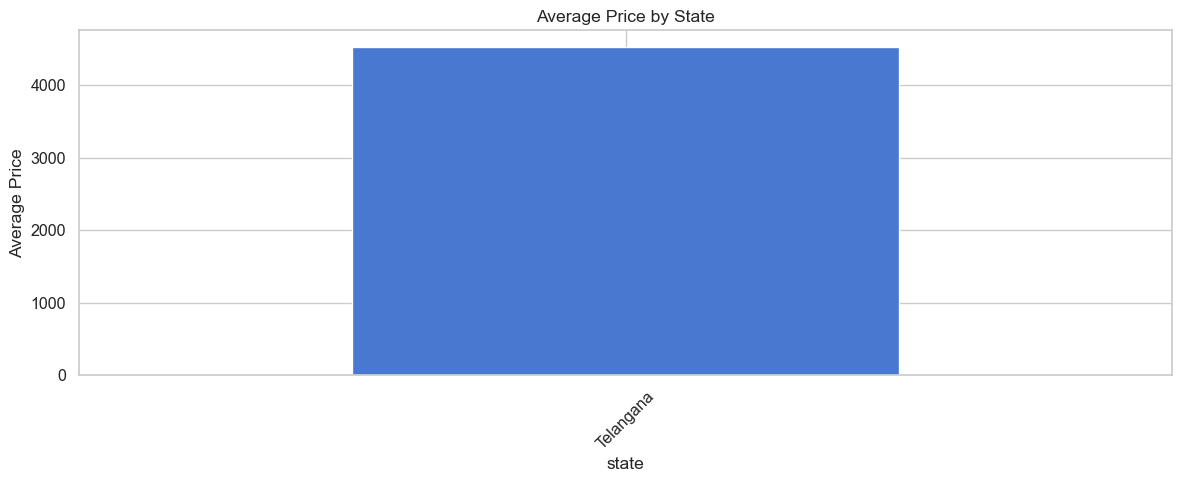

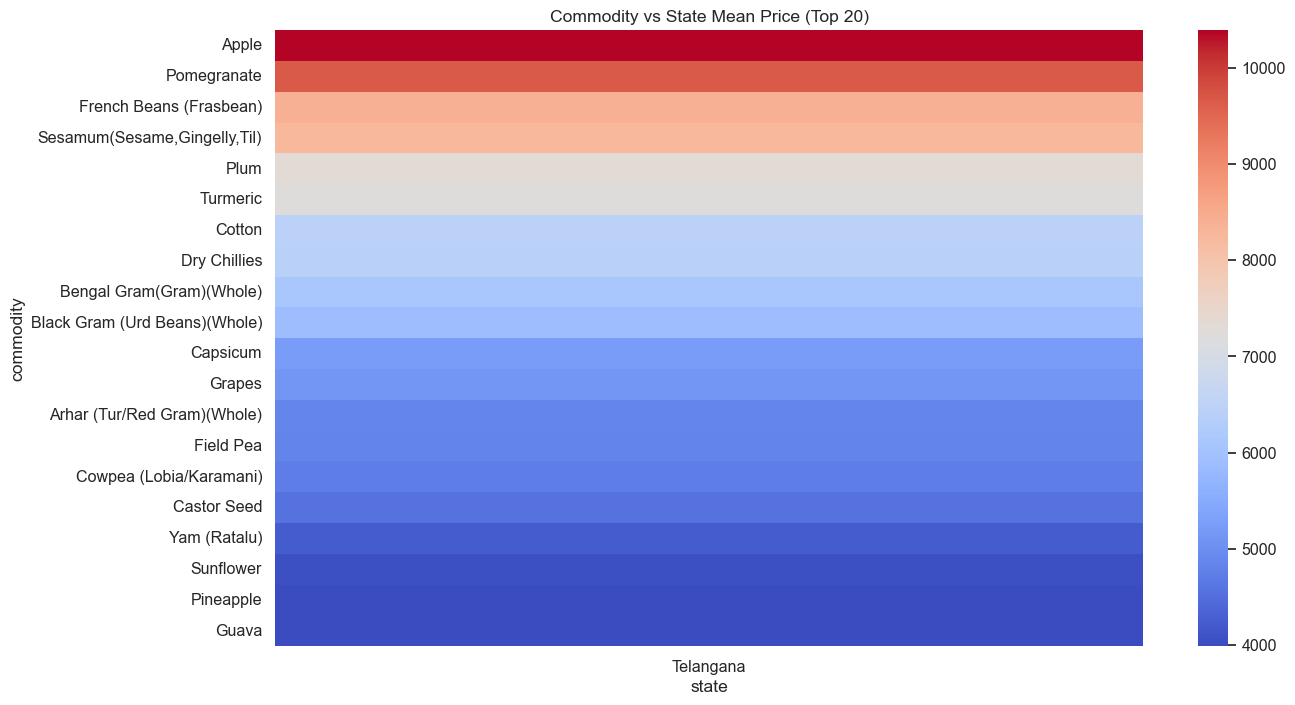

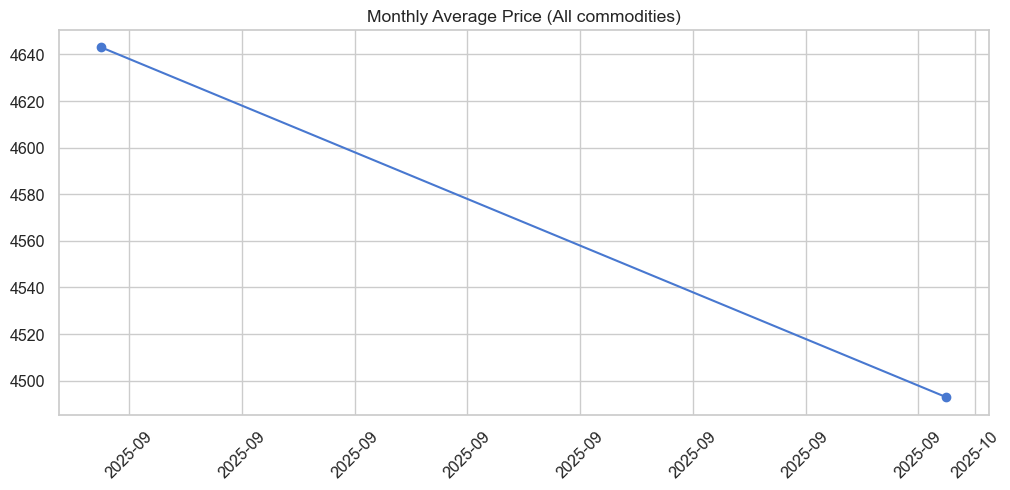

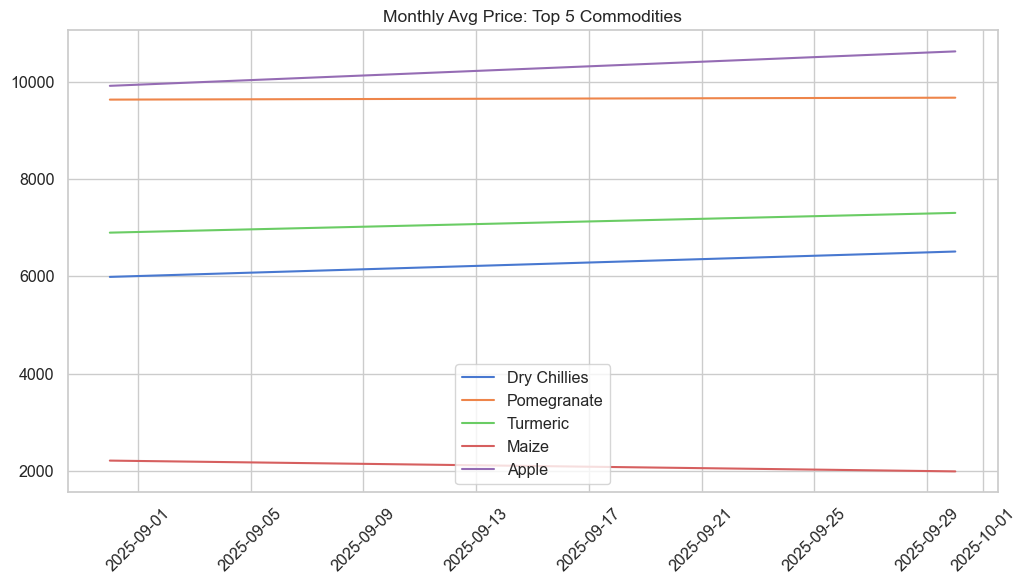

In [17]:
# 7) Visualizations (detailed)
import matplotlib.dates as mdates

# Avg price by state
if state_col and price_col:
    avg_state = df_clean.groupby(state_col)[price_col].mean().sort_values(ascending=False)
    plt.figure(figsize=(12,5))
    avg_state.plot(kind='bar')
    plt.title('Average Price by State')
    plt.ylabel('Average Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Heatmap of commodity vs state mean price
if commodity_col and state_col and price_col:
    pivot = df_clean.pivot_table(index=commodity_col, columns=state_col, values=price_col, aggfunc='mean')
    top_comm = pivot.mean(axis=1).sort_values(ascending=False).head(20).index
    pivot_top = pivot.loc[top_comm]
    plt.figure(figsize=(14,8))
    sns.heatmap(pivot_top, cmap='coolwarm')
    plt.title('Commodity vs State Mean Price (Top 20)')
    plt.show()

# Monthly trends and top5 commodities
if date_col and price_col:
    monthly_all = df_clean.set_index(date_col).resample('M')[price_col].mean().dropna()
    plt.figure(figsize=(12,5))
    plt.plot(monthly_all.index, monthly_all.values, marker='o')
    plt.title('Monthly Average Price (All commodities)')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.show()

if commodity_col:
    top5 = df_clean[commodity_col].value_counts().head(5).index.tolist()
    plt.figure(figsize=(12,6))
    for comm in top5:
        ser = df_clean[df_clean[commodity_col]==comm].set_index(date_col).resample('M')[price_col].mean()
        plt.plot(ser.index, ser.values, label=comm)
    plt.legend()
    plt.title('Monthly Avg Price: Top 5 Commodities')
    plt.xticks(rotation=45)
    plt.show()

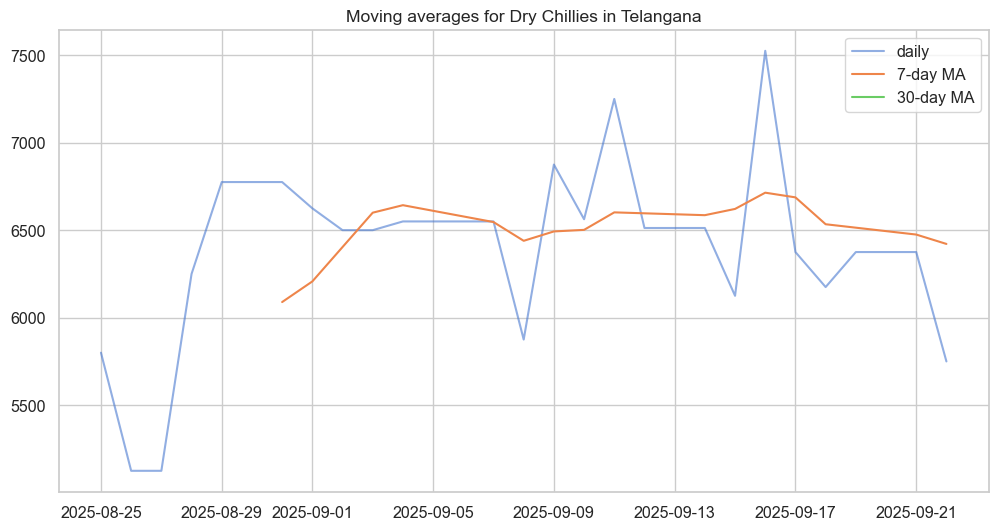

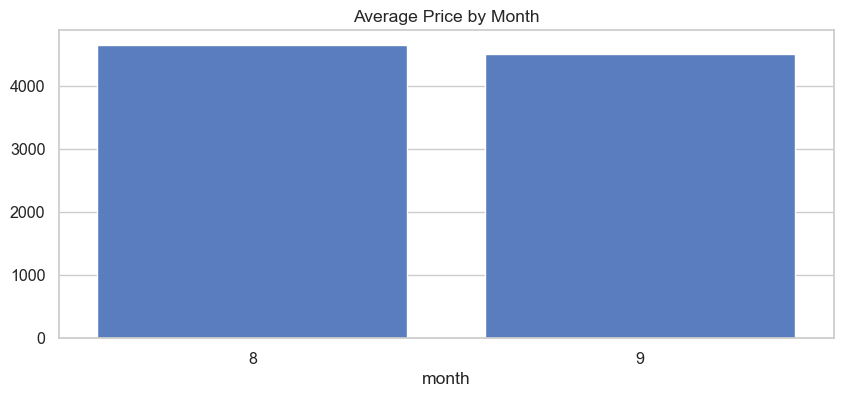

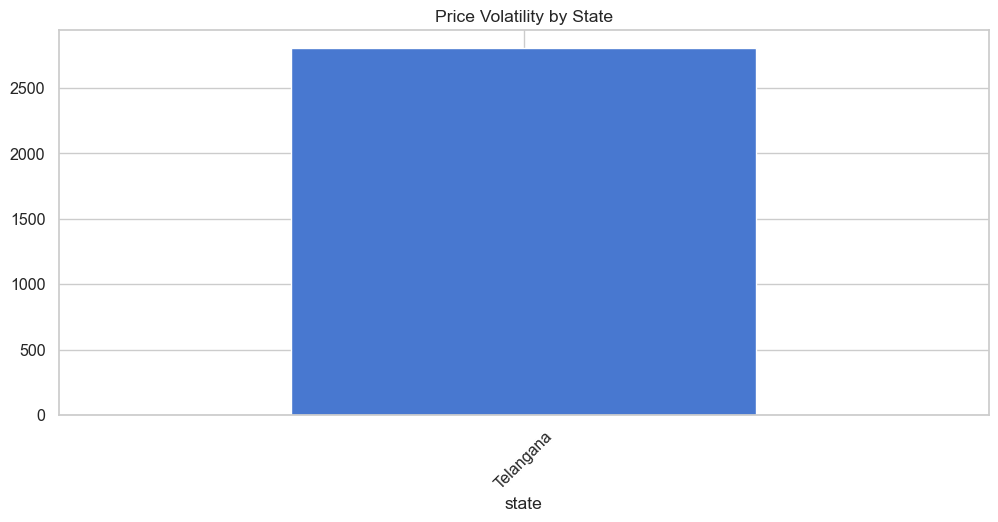

In [18]:
# 8) Advanced analytics: moving averages, seasonality, volatility
# Moving averages for top commodity-state
if commodity_col and state_col and date_col:
    comm = df_clean[commodity_col].value_counts().idxmax()
    st = df_clean[state_col].value_counts().idxmax()
    s = df_clean[(df_clean[commodity_col]==comm)&(df_clean[state_col]==st)].set_index(date_col).sort_index()
    if not s.empty:
        series = s[price_col].resample('D').mean().fillna(method='ffill')
        ma7 = series.rolling(7).mean()
        ma30 = series.rolling(30).mean()
        plt.figure(figsize=(12,6))
        plt.plot(series.index, series.values, label='daily', alpha=0.6)
        plt.plot(ma7.index, ma7.values, label='7-day MA')
        plt.plot(ma30.index, ma30.values, label='30-day MA')
        plt.title(f'Moving averages for {comm} in {st}')
        plt.legend()
        plt.show()

# Seasonality (month-wise)
if 'month' in df_clean.columns and price_col:
    month_avg = df_clean.groupby('month')[price_col].mean()
    plt.figure(figsize=(10,4))
    sns.barplot(x=month_avg.index, y=month_avg.values)
    plt.title('Average Price by Month')
    plt.show()

# Volatility hotspots
if state_col and price_col:
    state_vol = df_clean.groupby(state_col)[price_col].std().sort_values(ascending=False)
    plt.figure(figsize=(12,5))
    state_vol.plot(kind='bar')
    plt.title('Price Volatility by State')
    plt.xticks(rotation=45)
    plt.show()

In [19]:
# 9) Predictive Modeling (scikit-learn) - baseline models for price prediction
from sklearn.preprocessing import LabelEncoder
model_df = df_clean.copy()
features = []
if commodity_col: features.append(commodity_col)
if state_col: features.append(state_col)
if variety_col: features.append(variety_col)
if 'month' in model_df.columns: features.append('month')

model_df = model_df.dropna(subset=[price_col] + features)
print('Rows for modeling:', len(model_df))

if len(model_df) >= 200:
    le = LabelEncoder()
    for f in [c for c in features if model_df[c].dtype==object]:
        model_df[f+'_enc'] = le.fit_transform(model_df[f].astype(str))
    X_cols = [c for c in model_df.columns if c.endswith('_enc')] + [c for c in ['month'] if c in model_df.columns]
    X = model_df[X_cols]
    y = model_df[price_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    lr.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    for name, m in [('LinearRegression', lr), ('RandomForest', rf)]:
        preds = m.predict(X_test)
        print(name)
        print('MAE:', mean_absolute_error(y_test, preds))
        print('RMSE:', mean_squared_error(y_test, preds, squared=False))
        print('R2:', r2_score(y_test, preds))
    # Feature importance
    importances = rf.feature_importances_
    feat_imp = sorted(zip(X_cols, importances), key=lambda x: x[1], reverse=True)
    print('\nFeature importances:')
    for f, imp in feat_imp:
        print(f, round(imp,4))
else:
    print('Not enough rows for modeling. Need >=200 rows.')

Rows for modeling: 1075
LinearRegression
MAE: 2161.1150837277073
RMSE: 2606.1248482798646
R2: -0.022026933887623112
RandomForest
MAE: 594.8816800077058
RMSE: 912.144144801
R2: 0.8748015776428902

Feature importances:
variety_enc 0.5022
commodity_enc 0.4868
month 0.011
state_enc 0.0


In [20]:
# 10) PySpark MLlib templates for production-scale modeling (uncomment to run with Spark)
# from pyspark.sql import SparkSession, functions as F
# from pyspark.sql.window import Window
# spark = SparkSession.builder.appName('CommodityPriceAnalysis').config('spark.driver.memory','8g').getOrCreate()
# sdf = spark.read.option('header',True).option('inferSchema',True).csv('commodity_prices.csv')
# sdf = sdf.withColumn('date', F.to_date(F.col('date'), 'yyyy-MM-dd'))
# sdf = sdf.withColumn('price', F.col('modal_price').cast('double'))
# sdf = sdf.dropna(subset=['price'])
# sdf.createOrReplaceTempView('market')
# # Example SQL
# spark.sql('SELECT state, commodity, AVG(price) as avg_price FROM market GROUP BY state, commodity ORDER BY avg_price DESC').show(20)
# # MLlib pipeline example
# from pyspark.ml.feature import StringIndexer, VectorAssembler
# from pyspark.ml.regression import GBTRegressor
# from pyspark.ml import Pipeline
# idx1 = StringIndexer(inputCol='commodity', outputCol='commodity_idx', handleInvalid='keep')
# idx2 = StringIndexer(inputCol='state', outputCol='state_idx', handleInvalid='keep')
# idx3 = StringIndexer(inputCol='variety', outputCol='variety_idx', handleInvalid='keep')
# assembler = VectorAssembler(inputCols=['commodity_idx','state_idx','variety_idx','month'], outputCol='features')
# gbt = GBTRegressor(featuresCol='features', labelCol='price')
# pipeline = Pipeline(stages=[idx1, idx2, idx3, assembler, gbt])
# train, test = sdf.randomSplit([0.8,0.2], seed=42)
# model = pipeline.fit(train)
# pred = model.transform(test)
# from pyspark.ml.evaluation import RegressionEvaluator
# evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='rmse')
# print('RMSE:', evaluator.evaluate(pred))

## 11) Key Insights, Recommendations & Conclusion

**Key Insights (after running notebook):**
- Identify high-volatility commodities and states needing policy attention.
- Seasonal months where prices peak or dip — guide farmers accordingly.

**Recommendations:**
1. Deploy SMS/app forecasts for farmers with sell advisories.
2. Use volatility measures for buffer stock policy decisions.
3. Improve storage in low-price states; incentivize transportation to better markets.

**Conclusion:**
This notebook mirrors your Insurance Analytics layout while focusing on commodity prices. It is ready to be run locally. For production-scale training, use the PySpark templates.

_Notebook generated: 2025-10-05 13:48 UTC_
